In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr
import pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=2375df6a99a6d7f6d28878fef1e0389015ed6a3e179d391ff456b9aa94fe7e90
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [ ]:
def pre_processing(img_bin):
  #vertical lines
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img_bin).shape[1]//220))
  eroded_image = cv2.erode(img_bin, vertical_kernel, iterations=5)
  vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)
  #horizontal lines
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img_bin).shape[1]//50, 1))
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=5)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)
  #tables
  tables  = vertical_lines+horizontal_lines
  thresh, vertical_horizontal_lines = cv2.threshold(tables,100,255, cv2.THRESH_BINARY)
  #3d to 2d
  vertical_horizontal_lines=~vertical_horizontal_lines[:,:,0]
  return vertical_horizontal_lines

In [ ]:
def div_tables(img_rgb,vertical_horizontal_lines):
  lis_dup = []
  lis_orig = []
  lis = []
  lis2 =[]
  cnt = 0
  name = 0
  for i in range(len(vertical_horizontal_lines)):
    if list(vertical_horizontal_lines[i]).count(0) == 0:
      if len(lis) > 10:
        lis_dup.append([lis])
        lis_orig.append(np.array(lis2))
      lis = []
      lis2 = []
      cnt = 0
      continue
    else:
      lis.append(list(vertical_horizontal_lines[i]))
      lis2.append(list(img_rgb[i]))
      cnt = cnt + 1
    name = name +1
  return lis_dup,lis_orig        

In [ ]:
def extract_text(lis_dup,lis_orig):
  contours, hierarchy = cv2.findContours(np.array(lis_dup), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in contours]
  (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
  key=lambda x:x[1][1]))
  boxes = []
  print("one")
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      image = cv2.rectangle(lis_orig,(x,y),(x+w,y+h),(0,255,0),2)
      boxes.append([x,y,w,h])
  rows=[]
  columns=[]
  heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
  columns.append(boxes[0])
  previous=boxes[0]
  for i in range(1,len(boxes)):
      if(boxes[i][1]<=previous[1]):
          columns.append(boxes[i])
          previous=boxes[i]
          if(i==len(boxes)-1):
              rows.append(columns)
      else:
          rows.append(columns)
          columns=[]
          previous = boxes[i]
          columns.append(boxes[i])
  dataframe_final=[]
  for j in range(len(rows)):
    s=''
    for k in range(len(rows[j])):
        y,x,w,h = rows[j][k][0],rows[j][k][1], rows[j][k][2],rows[j][k][3]
        if len(rows) != 1:
          roi = lis_orig[x:x+h, y:y+w]
        else:
          roi = lis_orig
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
        resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        #dilation = cv2.dilate(resizing, kernel,iterations=2)
        #erosion = cv2.erode(resizing, kernel,iterations=5)
        out = pytesseract.image_to_string(resizing)

        s = s +" "+ out
    dataframe_final.append([s])
  return dataframe_final

In [ ]:
import pandas as pd
def data_frm(x):
  lat = []
  for i in x:
    spt = i[0].split("\x0c")
    for j in spt:
      if j != '':
        lat.append(j.replace("\n",""))
  name = []
  info = []
  edi = []
  for i in reversed(lat):
    edi.append(i)
  for i in range(len(edi)):
    if i %2==0:
      name.append(edi[i])
    else:
      info.append(edi[i])
  df = pd.DataFrame(columns = [name[-2],info[-2]])
  print(info)
  for i in range(len(info)-1):
    df=df.append({str(name[-2]):name[i],str(info[-2]):info[i]},ignore_index=True)
  return df

True

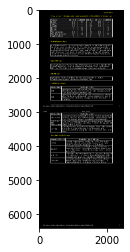

In [ ]:
img = '/content/drive/MyDrive/farmers/Kadapa.png'
img_bgr = np.array(cv2.imread(img, cv2.IMREAD_COLOR))
img_rgb  = np.array(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
thresh,img_bin = cv2.threshold(img_rgb,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
img_bin=img_bin[600:,:]
plt.imshow(img_bin)
cv2.imwrite('./new.jpg',img_bin)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

In [ ]:
tables = pre_processing(img_bin)

In [ ]:
cv2.imwrite('./nw5.jpg',tables)

True

In [ ]:
lst_tab,lst_values = div_tables(img_bin,tables)

In [ ]:
len(lst_tab)

7

In [ ]:
len(lst_values)

7

In [ ]:
for i in range(len(lst_values)):
  cv2.imwrite('x'+str(i)+'.jpg',lst_values[i])

In [ ]:
d = {}
for i in range(len(lst_values)):
  x = extract_text(lst_tab[i][0],lst_values[i])
  if len(x) != 1:
    d[i]=data_frm(x)
  else:
    d[i]=x[0]
    continue

one
[' ', ' ', ' ', ' pm)!', ' 280', ' 290', ' BRU', ' 12.0', ' Re', ' ', ' ', ' ', ' ', ' ', ' ', ' are)', ' aR’', ' 25.3', ' 32.0', ' are', ' SRR', ' 12.0', ' ', ' 12.0', ' 2021-09-08', ' yA PA eee', ' 2021-09-12', ' ', ' ', ' 290 ']
one
one
one
one
[' In paddy present weather conditions may favourable for the incidence of gallmidgeand leaf mite. To control gall midge apply Carbofuran 3G granules @10 kg per acreand for the control of leaf mite spray Profenophos @2.0 ml or Propargite @2.0 mlee Umey AVE lKele ', ' In paddy present weather conditions may favourable for the incidence of leaf folderand stem borer. To control spray chlorpyriphos @ 2.5ml/lit or cartaphydrochloride.O g/lit or Chlorantraniliprole 0.3 ml/ lit of water. ', ' Crop Specific Advisory', ' Crop Specific AdvisoryIn paddy present weather conditions may favourable for the incidence of leaf folderand stem borer. To control spray chlorpyriphos @ 2.5ml/lit or cartaphydrochloride.O g/lit or Chlorantraniliprole 0.3 ml/ lit 

In [ ]:
d[1]

[' As per the forecast received from Meteorological Centre, Amaravati, very light rainfall to light rainfall\n(2.0-12.0 mm) forecast during the next five days in Y.S.R dist. The maximum temperature will be 32.0-\n\n34.4 °C and the minimum temperature will be 24.9-25.8 °C. Morning relative humidity will be 79-81 %\n\nand afternoon relative humidity will be 42-54 %. Mainly North-West winds with a speed of 12.0-14.0\nmph will blow during the next five days. As per ERFS from August 12th September to September\n\n18th, 2021 the maximum temperatures are below normal and minimum temperatures are normal and\n\nnormal rainfall may receive over Rayalaseema.\n\n \n\x0c As per the forecast received from Meteorological Centre, Amaravati, very light rainfall to light rainfall\n(2.0-12.0 mm) forecast during the next five days in Y.S.R dist. The maximum temperature will be 32.0-\n\n34.4 °C and the minimum temperature will be 24.9-25.8 °C. Morning relative humidity will be 79-81 %\n\nand afternoon rela

In [ ]:
d[2]

[' According to Standardised Precipitation Index (SPI) for the period 5th August to 1st September 2021,\n\nModerately dry conditions exist in YSR district where as Normalized Difference Vegetation Index\n(NDVI) map (27.08.2021 to 02.09.2021) the agriculture vigor was moderate over the district.\n\n \n\x0c According to Standardised Precipitation Index (SPI) for the period 5th August to 1st September 2021,\n\nModerately dry conditions exist in YSR district where as Normalized Difference Vegetation Index\n(NDVI) map (27.08.2021 to 02.09.2021) the agriculture vigor was moderate over the district.\n\n \n\x0c']

In [ ]:
lat = []
for i in x:
  spt = i[0].split("\x0c")
  for j in spt:
    if j != '':
      lat.append(j.replace("\n",""))
name = []
info = []
edi = []
for i in reversed(lat):
  edi.append(i)
for i in range(len(edi)):
  if edi[i] != ' ':
    if i %2==0:
      name.append(edi[i])
    else:
      info.append(edi[i])

In [ ]:
name

[' TURMERIC', ' oI DEB YES', ' BANANA ', ' MANGO', ' Horticulture(Varieties)']

In [ ]:
x

[[' \x0c \x0c'],
 [' Horticulture Specific Advisory\n\x0c Horticulture(Varieties)\n\x0c'],
 [' Incorporate green manure crops when the crop is at 50 % flowering.It will\n\nincreases the soil fertility and water holding capacity of the soil. For the\ncontrol of leaf webber spray quinolphos@2.0 ml per lit of water.\n\n \n\x0c MANGO\n\x0c'],
 [' Present weather conditions are favourable for the incidence and spread of\nsigatoka leaf spot disease. To prevent the spread of disease propiconazole @\n\n1.0 ml (or) tebuconazole + trifloxystrobin @ 1.5 ml per litre for 2-3 times in\n30 days interval.\n\n \n\x0c BANANA\n\n \n\x0c'],
 [' For the control of leaf-eating caterpillars in Acid Lime , spray with Fenvalerate\n\n2.0 ml or Dimethoate 1.5 ml in water. A chemical DiPel containing Bacillus\nthuringiensis can be sprayed with 1.0 g per liter of water for better results.\n\n \n\x0c oI DEB YES\n\x0c'],
 [' Present weather conditions are favourable for the incidence of leaf blotch\n\ndisease in Tu

In [ ]:
info

[' Present weather conditions are favourable for the incidence of leaf blotchdisease in Turmeric. Spray Carbendazim@1.0 g or Mancozeb@2.5 g orThiophanate Methyl@ 1.0 g per lit of water for the control of disease. ',
 ' For the control of leaf-eating caterpillars in Acid Lime , spray with Fenvalerate2.0 ml or Dimethoate 1.5 ml in water. A chemical DiPel containing Bacillusthuringiensis can be sprayed with 1.0 g per liter of water for better results. ',
 ' Present weather conditions are favourable for the incidence and spread ofsigatoka leaf spot disease. To prevent the spread of disease propiconazole @1.0 ml (or) tebuconazole + trifloxystrobin @ 1.5 ml per litre for 2-3 times in30 days interval. ',
 ' Incorporate green manure crops when the crop is at 50 % flowering.It willincreases the soil fertility and water holding capacity of the soil. For thecontrol of leaf webber spray quinolphos@2.0 ml per lit of water. ',
 ' Horticulture Specific Advisory']

In [ ]:
df.head()

,ICrop(Varieties),| Crop Specific Advisory |
0,CASTOR,Prevailing conditions are favorable for inci...
1,COTTON,t present Cotton crop at flowering to pod de...
2,MAIZE,Farmers are advised to monitor incidence of ...
3,RICE,t present Rice crop at transplanting to till...


In [ ]:
len(a)

8

In [ ]:
len(b)

8